<a href="https://colab.research.google.com/github/m0421/object-detection/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

Mounted at /content/drive


**画像の前処理**

In [2]:
#標準化関数
def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [3]:
im=Image.open('drive/My Drive/DL_Basic/detection/data/image.jpg')
im_resize = im.resize(size=(300,300)) #画像サイズを300*300resize
im=np.array(im_resize)
im=zscore(im) #標準化
im=list(im)
k=[]
k.append(im)
im=np.array(k)
im.shape

(1, 300, 300, 3)

**推論**

In [4]:
precision='fp32' #精度 flost16 float32
#学習済モデルをダウンロード
ssd_model=torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils=torch.hub.load('NVIDIA/DeepLearningExamples:torchhub','nvidia_ssd_processing_utils')
#モデルをgpuに移動
ssd_model.to('cuda')
#ssd_model、utils 学習済モデル
#batchnormとdropoutレイヤーをevalモードにする。
ssd_model.eval()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

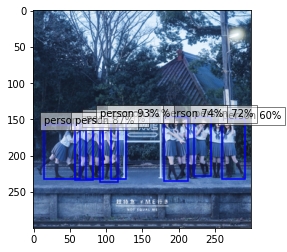

In [8]:
tensor=utils.prepare_tensor(im, precision=='fp16') #テンソルに変換
#画像url
image=Image.open('drive/My Drive/DL_Basic/detection/data/image.jpg')
image=image.resize(size=(300,300))
#物体検出処理
#autograd機能をオフにして使用量を減らして計算量を向上させてから推論処理を行う。
with torch.no_grad():
    detections_batch=ssd_model(tensor)

results_per_input=utils.decode_results(detections_batch) #ここで信頼度を算出
best_results_per_input=[utils.pick_best(results, 0.60) for results in results_per_input] #閾値を調整

#クラス情報(数値)をラベルに変換処理
classes_to_labels=utils.get_coco_object_dictionary()

#描画
for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    ax.imshow(image) #ここで画像を表示
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x,y,w,h =[val *300 for val in [left, bot, right - left, top - bot]] #検出したところの座標
        #長方形を描画
        rect=patches.Rectangle((x, y), w, h, 
                                 linewidth=1.5, 
                                 edgecolor='b', 
                                 facecolor='none')
        ax.add_patch(rect)

        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], #物体名
                                          confidences[idx]*100), #信頼度
                bbox=dict(facecolor='white', alpha=0.5)
                )
plt.show()